## Non-Local Means (NLM)

 

El algoritmo Non-Local Means (NLM) es una técnica para quitar ruido de una imagen aprovechando que muchas zonas de la imagen se parecen entre sí. En lugar de fijarse solo en los píxeles cercanos a uno concreto (como hacen los filtros clásicos), NLM busca otras regiones de la imagen que tengan un patrón similar, aunque estén lejos.

La idea es la siguiente: 
- Alrededor de cada píxel se toma un pequeño bloque o parche. 
- El parche se compara con otros parches de la imagen. 
- Si dos parches se parecen mucho, el píxel central del segundo tendrá mucha influencia en el valor final; si se parecen poco, apenas contará. 
- El nuevo valor del píxel se obtiene como una media ponderada de muchos otros píxeles, donde los más parecidos pesan más.

Gracias a esto, el filtro consigue reducir el ruido sin difuminar demasiado los bordes ni las texturas, algo que suele pasar con los filtros tradicionales basados en promedios locales. Por eso NLM es especialmente útil cuando se quiere mejorar la calidad visual de imágenes degradadas por ruido o compresión.




In [41]:
%%writefile -a ../src/NLM.py

'''
Implementación del filtro de eliminación de ruido Non-Local Means (NLM).
Este filtro se utiliza en la etapa de decodificación para reducir artefactos 
de compresión promediando parches similares en la imagen.
'''

import numpy as np
import logging
import cv2
import no_filter

# Metadatos para el framework de la asignatura
with open("/tmp/description.txt", 'w') as f:
    f.write(__doc__)


import parser
import main

# Configuración de parámetros por defecto según estándares de OpenCV
VALOR_H_POR_DEFECTO = 3      # Fuerza del filtro 
VENTANA_BUSQUEDA = 21        # Tamaño del área donde se buscan parches similares
VENTANA_PARCHE = 7           # Tamaño del bloque comparativo 

# Añadir argumentos específicos al parser del decodificador
# Se utiliza el flag -s según lo indicado en la documentación de la asignatura
parser.parser_decode.add_argument(
    "-s", "--filter_size", 
    type=parser.int_or_str, 
    help=f"Fuerza del filtro NLM 'h' (por defecto: {VALOR_H_POR_DEFECTO})", 
    default=VALOR_H_POR_DEFECTO
)

class CoDec(no_filter.CoDec):
    """
    Clase CoDec que integra el algoritmo Non-Local Means como filtro 
    de post-procesamiento durante la decodificación.
    """

    def __init__(self, args):
        """
        Constructor de la clase.
        Args:
            args: Argumentos de línea de comandos que contienen la configuración del filtro.
        """
        logging.debug(f"Inicializando filtro NLM con argumentos={args}")
        super().__init__(args)
        self.args = args

    def decode(self):
        """
        Flujo de decodificación estándar:
        1. Lectura de datos comprimidos.
        2. Descompresión al dominio espacial.
        3. Aplicación del filtro NLM para mejorar la calidad visual percibida.
        4. Escritura del resultado final.
        """
        datos_comprimidos = self.decode_read()
        imagen_reconstruida = self.decompress(datos_comprimidos)
        
        logging.debug(f"Dimensiones de imagen reconstruida: {imagen_reconstruida.shape}")
        
        # Aplicación de la etapa de filtrado
        imagen_filtrada = self.filter(imagen_reconstruida)
        
        tamano_salida = self.decode_write(imagen_filtrada)
        return tamano_salida
            
    def filter(self, img):
        """
        Aplica el algoritmo Non-Local Means Denoising.        
        """
        try:
            # El parámetro 'h' controla la agresividad del filtro.
            # Valores altos eliminan más ruido pero pueden difuminar detalles finos.
            fuerza_h = int(self.args.filter_size)
            
            logging.info(f"Aplicando NLM: h={fuerza_h}, parche={VENTANA_PARCHE}, ventana={VENTANA_BUSQUEDA}")

            # Robustez: OpenCV requiere que la imagen sea de tipo uint8 (8 bits)
            if img.dtype != np.uint8:
                img = img.astype(np.uint8)

            # Verificación de canales (Color vs Blanco y Negro)
            if len(img.shape) == 3:
                # Versión optimizada para imágenes en color
                return cv2.fastNlMeansDenoisingColored(
                    img, 
                    None, 
                    h=fuerza_h, 
                    hColor=fuerza_h, 
                    templateWindowSize=VENTANA_PARCHE, 
                    searchWindowSize=VENTANA_BUSQUEDA
                )
            else:
                # Versión para imágenes en escala de grises
                return cv2.fastNlMeansDenoising(
                    img, 
                    None, 
                    h=fuerza_h, 
                    templateWindowSize=VENTANA_PARCHE, 
                    searchWindowSize=VENTANA_BUSQUEDA
                )
                
        except Exception as e:
            # Manejo de errores para evitar que el programa se detenga si falla el filtrado
            logging.error(f"Error durante el filtrado NLM: {e}. Se devuelve imagen original.")
            return img

if __name__ == "__main__":
    # Integración con el flujo de ejecución principal de la asignatura
    main.main(parser.parser, logging, CoDec)

Appending to ../src/NLM.py


In [24]:
from IPython.display import Image, display

Downloaded http://www.hpca.ual.es/~vruiz/images/pajarillo_512x512.png


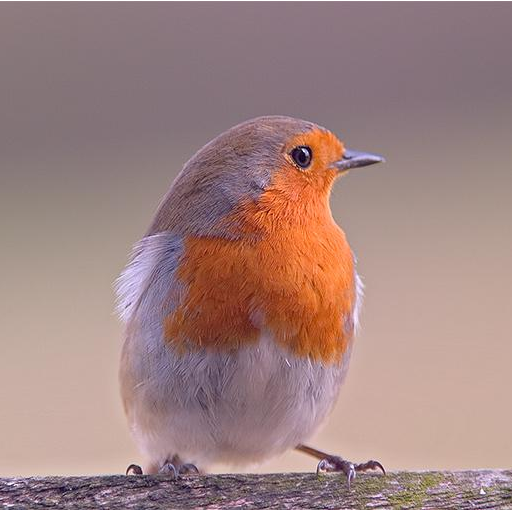

In [23]:
# Descargar imagen por defecto
%run download_default_image.ipynb

## Usage y opciones generales
Comprobamos los argumentos principales del script.

In [29]:
!python ../src/NLM.py -h

usage: NLM.py [-h] [-g] {encode,decode} ...

Filter's common interface.

positional arguments:
  {encode,decode}  You must specify one of the following subcomands:
    encode         Compress data
    decode         Uncompress data

options:
  -h, --help       show this help message and exit
  -g, --debug      Output debug information (default: False)


## Opciones de codificación

In [30]:
!python ../src/NLM.py encode -h

usage: NLM.py encode [-h] [-c ENTROPY_IMAGE_CODEC]

options:
  -h, --help            show this help message and exit
  -c ENTROPY_IMAGE_CODEC, --entropy_image_codec ENTROPY_IMAGE_CODEC
                        Entropy Image Codec (default: TIFF)


## Opciones de decodificación
Aquí se puede observar el parámetro `-s` correspondiente al tamaño/fuerza del filtro NLM.

In [31]:
!python ../src/NLM.py decode -h

usage: NLM.py decode [-h] [-c ENTROPY_IMAGE_CODEC]

options:
  -h, --help            show this help message and exit
  -c ENTROPY_IMAGE_CODEC, --entropy_image_codec ENTROPY_IMAGE_CODEC
                        Entropy Image Codec (default: TIFF)


In [36]:
%%bash
# Codificación
python ../src/NLM.py encode -i /tmp/original.png -o /tmp/original.nlm

# Decodificación aplicando el filtro NLM con fuerza 10
python ../src/NLM.py decode -i /tmp/original.nlm -o /tmp/decoded.png -f NLM -s 12

main Namespace(debug=False, subparser_name='encode', entropy_image_codec='TIFF', original='/tmp/original.nlm', encoded='/tmp/encoded', func=<function encode at 0x7635fbdbcfe0>)


(INFO) entropy_image_coding: Written 275514 bytes in /tmp/encoded.tif


main Namespace(debug=False, subparser_name='decode', entropy_image_codec='TIFF', encoded='/tmp/encoded', decoded='/tmp/decoded.png', filter_size=12, func=<function decode at 0x7811e6b049a0>)


(INFO) NLM: Aplicando NLM: h=12, parche=7, ventana=21


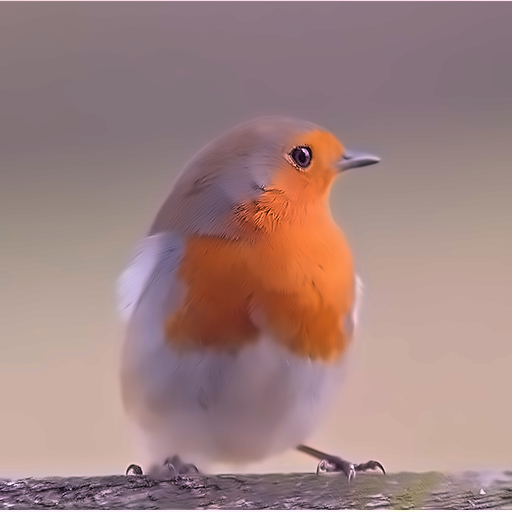

In [37]:
from IPython.display import Image, display
display(Image(filename="/tmp/decoded.png"))

In [34]:
%%bash
python ../src/RDE.py

Code-stream file: /tmp/encoded.tif length: 275514
Original image: /tmp/original.png 215071 bytes (6.56) bits/pixel
Code-stream: ['/tmp/encoded.tif'] 275514 bytes (8.41) bits/pixel
Decoded image: /tmp/decoded.png 166578 bytes (5.08) bits/pixel
Images shape: (512, 512, 3)
Distortion (RMSE): 5.24
J = R + D = 13.65


In [35]:
%%bash
rm /tmp/encoded*

Grupo: 
- Jaime Parra Jiménez
- Alejandro Sánchez Rodríguez